## Setup

Import the basic libraries.

In [2]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display
import os
%matplotlib inline

Initialize the environment for running the experiment.

In [3]:
os.makedirs('./results/BiGaussian_MINE/', exist_ok=True)

# Paths for loading/storing results.
name = 'results/BiGaussian_MINE' # filename
chkpt_name = name+'.pt'              # checkpoint
fig_name = name+'.pdf'               # output figure

# use GPU if available
if torch.cuda.is_available(): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    
# initialize random seed
np.random.seed(0)
torch.manual_seed(0)

## Data 

Generate data using the mixed gaussian model.

In [4]:
from data.mix_gaussian import MixedGaussian

In [5]:
sample_size = 400   # sample size
rho = 0.9           # model parameter
p = 0.8             # parameter of 
rep = 1             # number of repeated runs
d = 1               # number of dimensions for X (and Y)

X = np.zeros((rep,sample_size,d))
Y = np.zeros((rep,sample_size,d))
data_Z = np.zeros((rep,sample_size,2*d))
data_Y = np.zeros((rep,sample_size,2*d))
data_X = np.zeros((rep,sample_size,d))
mg = MixedGaussian(sample_size=sample_size,mean1=1, mean2=1,rho1=rho,rho2=-rho,mix2=0.8)

for i in range(rep):
    for j in range(d):
        data = mg.data
        X[i,:,j] = data[:,0]
        Y[i,:,j] = data[:,1]       
    data_Z[i] = np.append(X[i], Y[i], axis=1)

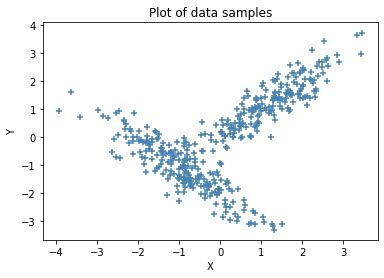

In [6]:
plt.scatter(X[0,:,0],Y[0,:,0],label="data",marker="+",color="steelblue")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of data samples')
plt.show()

Generate data from bernoulli distribution

In [7]:
from scipy.stats import bernoulli
for i in range(rep):
    X = bernoulli.rvs(p, size=sample_size)
    X[np.where(X==0)] = -1
    data_X[i] = X.reshape(sample_size, d)

# data_Y is the product of data from bernoulli distribution and mixed Gaussian distribution.
for i in range(rep):
    for j in range(sample_size):
        data_Y[i,j] = data_X[i,j] * data_Z[i,j]

## Model

Initialize the MINE model.

In [9]:
from model.mine import MINE

In [12]:
batch_size = 100       # batch size of data sample
lr = 1e-4              # learning rate
ma_rate = 0.1          # rate of moving average in the gradient estimate 

mine_list = []
for i in range(rep):
    mine_list.append(MINE(torch.Tensor(data_X[i]),torch.Tensor(data_Y[i]),
                            batch_size=batch_size,lr=lr,ma_rate=ma_rate))
dXY_list = np.zeros((rep,0))

Load previous results.

In [13]:
load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    dXY_list = checkpoint['dXY_list']
    
    mine_state_list = checkpoint['mine_state_list']
    for i in range(rep):
        minee_list[i].load_state_dict(mine_state_list[i])
    print('Previous results loaded.')

Continuously train the model. The following can be executed repeatedly and after loading previous results.

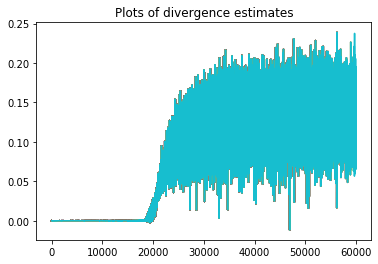

In [22]:
continue_train = True  # set to True to continue to train
num_big_steps = 100     # number of small steps
num_small_steps = 400  # number of big steps
if continue_train:
    for k in range(num_big_steps):
        for j in range(num_small_steps):
            dXY_list = np.append(dXY_list, np.zeros((rep, 1)), axis=1)
            for i in range(rep):
                mine_list[i].step()
                dXY_list[i, -1] = mine_list[i].forward()
        # To show intermediate works
        for i in range(rep):
            plt.plot(dXY_list[i, :],label='dXY')
            plt.title('Plots of divergence estimates')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

Save current results.

In [16]:
overwrite = False  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    mine_state_list = [mine_list[i].state_dict() for i in range(rep)]
    torch.save({
        'dXY_list': dXY_list,
        'mine_state_list': mine_state_list
    }, chkpt_name)
    print('Current results saved.')

Current results saved.


## Analysis 

Calculate the ground truth mutual information.

In [20]:
mi = mg.mix_ground_truth
print('MI Ground truth is {0} nats.'.format(mi)) 

MI Ground truth is 0.2225071668260794 nats.


Apply moving average to smooth out the mutual information estimate.

In [23]:
mi_ma_rate = 0.01            # rate of moving average
mi_list = dXY_list.copy()    # see also the estimate() member function of MINE
for i in range(1,dXY_list.shape[1]):
    mi_list[:,i] = (1-mi_ma_rate) * mi_list[:,i-1] + mi_ma_rate * mi_list[:,i]

Plot the mutual information estimate after different number of iterations. The red dashed line shows the ground truth, and the green dotted line is the number of iterations where 90% of the ground truth is reached.

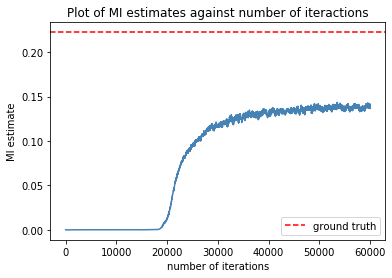

In [24]:
plt.figure()
for i in range(rep):
    plt.plot(mi_list[i,:],color='steelblue')
    for t in range(mi_list[i].shape[0]):
        if (mi_list[0,t]>.9*mi):
            plt.axvline(t,label='90% reached',linestyle=':',color='green')
            break
plt.axhline(mi,label='ground truth',linestyle='--',color='red')
plt.title("Plot of MI estimates against number of iteractions")
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.legend()
plt.savefig('./results/BiGaussian_MINE/MutualInfo.png')
plt.show()